In [18]:






import os

import numpy as np
import time
import math
import gc
import pandas as pd

from operator import itemgetter

import scipy
import matplotlib.pyplot as plt
import errno
import glob
from sklearn.metrics import cohen_kappa_score, f1_score, accuracy_score
import itertools
import tensorflow as tf

from sklearn.metrics import log_loss

import warnings
from collections import Counter, defaultdict
from random import shuffle
warnings.filterwarnings('ignore')
print('finish importing')


finish importing


In [19]:

def import2dArray(file_name, file_type="f", return_sparse=False):
    if file_name[-4:] == ".npz":
        print("Loading sparse array")
        array = sp.load_npz(file_name)
        if return_sparse is False:
            array = array.toarray()
    elif file_name[-4:] == ".npy":
        print("Loading numpy array")
        array = np.load(file_name)#
    else:
        with open(file_name, "r") as infile:
            if file_type == "i":
                array = [list(map(int, line.strip().split())) for line in infile]
            elif file_type == "f":
                array = [list(map(float, line.strip().split())) for line in infile]
            elif file_type == "discrete":
                array = [list(line.strip().split()) for line in infile]
                for dv in array:
                    for v in range(len(dv)):
                        dv[v] = int(dv[v][:-1])
            else:
                array = np.asarray([list(line.strip().split()) for line in infile])
        array = np.asarray(array)
    print("successful import", file_name)
    return array


def write1dArray(array, name):
    try:
        file = open(name, "w")
        print("starting array")
        for i in range(len(array)):
            file.write(str(array[i]))
            file.write("\n")
        file.close()
    except FileNotFoundError:
        print("FAILURE")
   

    print("successful write", name)
    
    
def write2dArray(array, name):
    try:
        file = open(name, "w")
        print("starting array")
        for i in range(len(array)):
            for n in range(len(array[i])):
                file.write(str(array[i][n]) + " ")
            file.write("\n")
        file.close()
    except FileNotFoundError:
        print("FAILURE")
    

    print("successful write", name)    



# Reading the files

In [20]:

# In[138]:

#Reading from files 
##############################################################################
##############################################################################
base_folder_results="//media/rana/2TB/MoECode/results/"

base_folder="/home/rana/mymodel4/building/"
#base_folder2="/home/rana/mymodel4/movies1/Tom/"
entity_file=base_folder+"final_ent.txt"
entityID_file=base_folder+"sorted_ent_wikiID"

feature_file=base_folder+"features3_that_have_Glove50d300.txt"

Wj_file=base_folder+"features3_Glove50d300.txt"
Co_file=base_folder+"BoWFinalReclean/"
ent=[]
fea=[]
idf=[]
with open(entity_file,"r") as f:
    for line in f:
        key= line.strip()
        ent.append(key)
with open(feature_file,"r")as f:
    for line in f:
        key=line.strip()
        fea.append(key)


entities=dict(zip(ent,range(len(ent))))
features=dict(zip(fea,range(len(fea))))




cooccurance=import2dArray(base_folder+'coaccuranceForMoe')#[number of words X number of entities]
co=np.transpose(cooccurance)



gloveVectors=[]
gloveVectors= import2dArray(Wj_file)
gloveVectors =np.array(gloveVectors)       

print(gloveVectors.shape)


#   create the dictionary    
cooccurrence_counts = defaultdict(float)

for i in range(0,len(ent)):
    countp=0
    countn=0
    if i%1000==0:
       
        print('finished :',i)
    for j in range(0,len(fea)):
        if(co[i][j])>0:
            cooccurrence_counts[(i, j)]=co[i][j]
        elif (co[i][j])==0:# and countn<1000:#<2000 is for negative sampling
            countn=countn+1
            cooccurrence_counts[(i, j)]=1.0
                    
cooccurrence_matrix = {
            (words[0], words[1]): count
            for words, count in cooccurrence_counts.items() if count>=0}
print('finish_Finally')



successful import /home/rana/mymodel4/building/coaccuranceForMoe
successful import /home/rana/mymodel4/building/features3_Glove50d300.txt
(9368, 300)
finished : 0
finished : 1000
finished : 2000
finished : 3000
finish_Finally


In [21]:
del co,cooccurrence_counts,cooccurance
gc.collect()


25588

# GloVe and GloVe MoE implementation (standard and  weighted version)

In [22]:


# In[4]:
# we used the implementation in https://github.com/GradySimon/tensorflow-glove

class NotTrainedError(Exception):
    pass

class NotFitToCorpusError(Exception):
    pass

class GloVeModel():
    def __init__(self, count_,entities,fea,embedding_size, entities_size, max_vocab_size=100000, min_occurrences=0,
                 scaling_factor=3/4, cooccurrence_cap=100, batch_size=512, learning_rate=0.05):
        self.embedding_size = embedding_size
        
        self.max_vocab_size = entities_size#max_vocab_size
        self.min_occurrences = min_occurrences
        self.scaling_factor = scaling_factor
        self.cooccurrence_cap = cooccurrence_cap
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        #self.mds= mds

        self.__words = fea
        self._entities=entities
        self.entities_size=len(entities)
        self.__word_to_id = [i for i in range(0,len(fea))]
        self.__cooccurrence_matrix = count_
        self.__embeddings = None
        self.__embeddings_en = None
       
    def fit_to_corpus(self, count_):

        self.__build_graph()

   
    def __build_graph(self):
        self.__graph = tf.Graph()
        with self.__graph.as_default(), self.__graph.device(_device_for_node):
            count_max = tf.constant([self.cooccurrence_cap], dtype=tf.float32,
                                    name='max_cooccurrence_count')
            scaling_factor = tf.constant([self.scaling_factor], dtype=tf.float32,
                                         name="scaling_factor")

            self.__focal_input = tf.placeholder(tf.int32, shape=[self.batch_size],
                                                name="focal_words")
            self.__context_input = tf.placeholder(tf.int32, shape=[self.batch_size],
                                                  name="context_words")
            self.__cooccurrence_count = tf.placeholder(tf.float32, shape=[self.batch_size],
                                           name="cooccurrence_count")

            self.__lamda=tf.placeholder(dtype=tf.float32)
            focal_embeddings = tf.Variable(
                tf.random_uniform([self.vocab_size, self.embedding_size], 1.0, -1.0),
                name="focal_embeddings")
            context_embeddings = tf.Variable(
                tf.random_uniform([self.entities_size, self.embedding_size], 1.0, -1.0),
                name="context_embeddings")
            

            focal_biases = tf.Variable(tf.random_uniform([self.vocab_size], 1.0, -1.0),
                                       name='focal_biases')
            context_biases = tf.Variable(tf.random_uniform([self.entities_size], 1.0, -1.0),
                                         name="context_biases")

            focal_embedding = tf.nn.embedding_lookup([focal_embeddings], self.__focal_input)
            
            #WEPrime=tf.constant(mds)
            #context_embedding = tf.nn.embedding_lookup([WEPrime], self.__context_input)
            context_embedding = tf.nn.embedding_lookup([context_embeddings], self.__context_input)
            focal_bias = tf.nn.embedding_lookup([focal_biases], self.__focal_input)
            context_bias = tf.nn.embedding_lookup([context_biases], self.__context_input)

            weighting_factor = tf.minimum(
                1.0,
                tf.pow(
                    tf.div(self.__cooccurrence_count, count_max),
                    scaling_factor))

            embedding_product = tf.reduce_sum(tf.multiply(focal_embedding, context_embedding), 1)
            #tf.log(tf.to_float(self.__cooccurrence_count))
            log_cooccurrences =tf.log (tf.to_float(self.__cooccurrence_count))

            distance_expr = tf.square(tf.add_n([
                embedding_product,
                focal_bias,
                context_bias,
                tf.negative(log_cooccurrences)]))
            
            single_losses =tf.multiply(weighting_factor, distance_expr)
            print('single_lose',single_losses.shape)
            #WEPrime=tf.constant(mds)

            #self.__squareEqludian=self.__lamda*(tf.reduce_sum(tf.square(tf.subtract(context_embeddings, WEPrime))))

            self.__total_loss = tf.reduce_sum(single_losses)#+self.__squareEqludian
            tf.summary.scalar("GloVe_loss", self.__total_loss)
            self.__optimizer = tf.train.AdagradOptimizer(self.learning_rate).minimize(
                self.__total_loss)
            self.__summary = tf.summary.merge_all()

            self.__combined_embeddings = focal_embeddings
            self.__entities_embeddings = context_embeddings
            self.__single_losses = single_losses
            self.__context_biases = context_biases
            self.__focal_biases = focal_biases
    def train(self, num_epochs, log_dir=None, summary_batch_interval=1000,
              tsne_epoch_interval=None):
        should_write_summaries = log_dir is not None and summary_batch_interval
        should_generate_tsne = log_dir is not None and tsne_epoch_interval
        batches = self.__prepare_batches()
        total_steps = 0
        with tf.Session(graph=self.__graph) as session:
            if should_write_summaries:
                print("Writing TensorBoard summaries to {}".format(log_dir))
                summary_writer = tf.summary.FileWriter(log_dir, graph=session.graph)
            tf.global_variables_initializer().run()
            count=0
            self.__losses=None
            allLoses=[]

            for epoch in range(num_epochs):
                loss_epoch=0
                allError=np.zeros((self.entities_size),dtype=np.float)

                count=count+1
                print('epoch:', count)
                shuffle(batches)
                #print('finish shuff')
                for batch_index, batch in enumerate(batches):
                    i_s, j_s, counts = batch
                    #print('servive batches')
                    if batch_index==len(batches)-1:
                        lamda=1000.0
                    else:
                        lamda=0.0
                    if len(counts) != self.batch_size:
                        continue
                    feed_dict = {
                        self.__focal_input: i_s,
                        self.__context_input: j_s,
                        self.__cooccurrence_count: counts,
                        self.__lamda:lamda}
                    _,loss,ErrorEst=session.run([self.__optimizer,self.__total_loss,self.__single_losses], feed_dict=feed_dict)
                    loss_epoch=loss_epoch+loss
                    for i in range(len(j_s)):
                        allError[j_s[i]]=allError[j_s[i]]+(ErrorEst)[i]
                    
                    #print(loss,' ')
                    if should_write_summaries and (total_steps + 1) % summary_batch_interval == 0:
                        summary_str = session.run(self.__summary, feed_dict=feed_dict)
                        summary_writer.add_summary(summary_str, total_steps)
                    total_steps += 1
                if should_generate_tsne and (epoch + 1) % tsne_epoch_interval == 0:
                    current_embeddings = self.__combined_embeddings.eval()
                    output_path = os.path.join(log_dir, "epoch{:03d}.png".format(epoch + 1))
                    self.generate_tsne(output_path, embeddings=current_embeddings)
                    
                allLoses.append(loss_epoch)
                
                print('self.__total_loss',loss_epoch)
            del(batch_index)
            del(i_s)
            del(j_s)
            del(counts)
            gc.collect()
            self.__losses=allLoses
            self.__single_lossesAll=allError
            self.__embeddings = self.__combined_embeddings.eval()
            self.__embeddings_en = self.__entities_embeddings.eval()
            self.__context_biasesE=self.__context_biases.eval()
            self.__focal_biasesW=self.__focal_biases.eval()
            del(batches)
            gc.collect()
            if should_write_summaries:
                summary_writer.close()
            
           
   
                
                
    def rana (self,f):
        print(self.entities_size)
        
    def embedding_for(self, word_str_or_id):
        if isinstance(word_str_or_id, str):
            return self.embeddings[self.__word_to_id[word_str_or_id]]
        elif isinstance(word_str_or_id, int):
            return self.embeddings[word_str_or_id]
    def __prepare_batches(self):
        if self.__cooccurrence_matrix is None:
            raise NotFitToCorpusError(
                "Need to fit model to corpus before preparing training batches.")
        cooccurrences = [(word_ids[0], word_ids[1], count)
                         for word_ids, count in self.__cooccurrence_matrix.items()]
        i_indices, j_indices, counts = zip(*cooccurrences)
        return list(_batchify(self.batch_size, i_indices, j_indices, counts))

 
    def embedding_for_ent(self, word_str_or_id):
       
        return self.__entities_embeddings[word_str_or_id]

    
    @property
    def vocab_size(self):
        return len(self.__words)

    @property
    def words(self):
        if self.__words is None:
            raise NotFitToCorpusError("Need to fit model to corpus before accessing words.")
        return self.__words
    @property
    def loss(self):
        if self.__losses is None:
            raise NotTrainedError("Need to train model before accessing embeddings")
        return self.__losses

    @property
    def embeddings(self):
        if self.__embeddings is None:
            raise NotTrainedError("Need to train model before accessing embeddings")
        return self.__embeddings
    @property
    def embeddings_en(self):
        if self.__embeddings_en is None:
            raise NotTrainedError("Need to train model before accessing embeddings")
        return self.__embeddings_en
    @property
    def errorEstimation(self):
        if self.__single_lossesAll is None:
            raise NotTrainedError("Need to train model before accessing embeddings")
        return self.__single_lossesAll
    @property
    def context_biasesE(self):
        if self.__context_biasesE is None:
            raise NotTrainedError("Need to train model before accessing embeddings")
        return self.__context_biasesE
    @property
    def focal_biasesW(self):
        if self.__focal_biasesW is None:
            raise NotTrainedError("Need to train model before accessing embeddings")
        return self.__focal_biasesW
    def id_for_word(self, word):
        if self.__word_to_id is None:
            raise NotFitToCorpusError("Need to fit model to corpus before looking up word ids.")
        return self.__word_to_id[word]

    def generate_tsne(self, path=None, size=(100, 100), word_count=1000, embeddings=None):
        if embeddings is None:
            embeddings = self.embeddings
        from sklearn.manifold import TSNE
        tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
        low_dim_embs = tsne.fit_transform(embeddings[:word_count, :])
        labels = self.words[:word_count]
        return _plot_with_labels(low_dim_embs, labels, path, size)


def _context_windows(region, left_size, right_size):
    for i, word in enumerate(region):
        start_index = i - left_size
        end_index = i + right_size
        left_context = _window(region, start_index, i - 1)
        right_context = _window(region, i + 1, end_index)
        yield (left_context, word, right_context)


def _window(region, start_index, end_index):
    """
    Returns the list of words starting from `start_index`, going to `end_index`
    taken from region. If `start_index` is a negative number, or if `end_index`
    is greater than the index of the last word in region, this function will pad
    its return value with `NULL_WORD`.
    """
    last_index = len(region) + 1
    selected_tokens = region[max(start_index, 0):min(end_index, last_index) + 1]
    return selected_tokens


def _device_for_node(n):
    if n.type == "MatMul":
        return "/cpu:0"
    else:
        return "/cpu:0"


def _batchify(batch_size, *sequences):
    for i in range(0, len(sequences[0]), batch_size):
        yield tuple(sequence[i:i+batch_size] for sequence in sequences)


def _plot_with_labels(low_dim_embs, labels, path, size):
    import matplotlib.pyplot as plt
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    figure = plt.figure(figsize=size)  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right',
                     va='bottom')
    if path is not None:
        figure.savefig(path)
        plt.close(figure)


# In[245]:


class GloVeModelMOE():
    def __init__(self, count_,entities,fea,g_K_j,empEnt1,empFea1, entbias1,feabias1,embedding_size, entities_size,max_vocab_size=100000, min_occurrences=0,
                 scaling_factor=3/4, cooccurrence_cap=100, batch_size=512, learning_rate=0.05):
        self.embedding_size = embedding_size
        
        self.max_vocab_size = entities_size#max_vocab_size
        self.min_occurrences = min_occurrences
        self.scaling_factor = scaling_factor
        self.cooccurrence_cap = cooccurrence_cap
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        #self.mds= mds

        self.__words = fea
        self._entities=entities
        print('len(entities)',len(entities))
        self.entities_size=len(entities)
        self.__word_to_id = [i for i in range(0,len(fea))]
        self.__cooccurrence_matrix = count_
        self.__embeddings = None
        self.__embeddings_en = None
        self.empEnt1=empEnt1
        self.empFea1=empFea1
        self.entbias1=entbias1
        self.feabias1=feabias1
        self.g_K_j=g_K_j
    def fit_to_corpus(self, count_):

        self.__build_graph()

   
    def __build_graph(self):
        self.__graph = tf.Graph()
        with self.__graph.as_default(), self.__graph.device(_device_for_node):
            count_max = tf.constant([self.cooccurrence_cap], dtype=tf.float32,
                                    name='max_cooccurrence_count')
            scaling_factor = tf.constant([self.scaling_factor], dtype=tf.float32,
                                         name="scaling_factor")

            self.__focal_input = tf.placeholder(tf.int32, shape=[self.batch_size],
                                                name="focal_words")
            self.__context_input = tf.placeholder(tf.int32, shape=[self.batch_size],
                                                  name="context_words")
            self.__cooccurrence_count = tf.placeholder(tf.float32, shape=[self.batch_size],
                                           name="cooccurrence_count")

            self.__lamda=tf.placeholder(dtype=tf.float32)
            focal_embeddings = tf.Variable(
                self.empFea1,
                name="focal_embeddings")
            context_embeddings = tf.Variable(
                self.empEnt1,
                name="context_embeddings")
            

            focal_biases = tf.Variable(self.feabias1,
                                       name='focal_biases')
            context_biases = tf.Variable(self.entbias1,
                                         name="context_biases")

            focal_embedding = tf.nn.embedding_lookup([focal_embeddings], self.__focal_input)
            # the probability from the gating network
            G_K_J = tf.constant(self.g_K_j)
            G_K_J_weight = tf.nn.embedding_lookup([G_K_J], self.__context_input)
            print(G_K_J_weight.shape)
            context_embedding = tf.nn.embedding_lookup([context_embeddings], self.__context_input)
            focal_bias = tf.nn.embedding_lookup([focal_biases], self.__focal_input)
            context_bias = tf.nn.embedding_lookup([context_biases], self.__context_input)
            #not used for simplicity
            weighting_factor = tf.minimum(
                1.0,
                tf.pow(
                    tf.div(self.__cooccurrence_count, count_max),
                    scaling_factor))

            embedding_product = tf.reduce_sum(tf.multiply(focal_embedding, context_embedding), 1)
            #tf.log(tf.to_float(self.__cooccurrence_count))
            log_cooccurrences = tf.log (tf.to_float(self.__cooccurrence_count))

            distance_expr = tf.square(tf.add_n([
                embedding_product,
                focal_bias,
                context_bias,
                tf.negative(log_cooccurrences)]))
            single_losses1 = tf.multiply(weighting_factor, distance_expr)
            single_losses = tf.multiply(G_K_J_weight, distance_expr)
            print('single_lose',single_losses.shape)
            #WEPrime=tf.constant(mds)

            #self.__squareEqludian=self.__lamda*(tf.reduce_sum(tf.square(tf.subtract(context_embeddings, WEPrime))))

            self.__total_loss = tf.reduce_sum(single_losses)#+self.__squareEqludian
            tf.summary.scalar("GloVe_loss", self.__total_loss)
            self.__optimizer = tf.train.AdagradOptimizer(self.learning_rate).minimize(
                self.__total_loss)
            self.__summary = tf.summary.merge_all()

            self.__combined_embeddings = focal_embeddings
            self.__entities_embeddings = context_embeddings
            self.__single_losses = single_losses1
            self.__context_biases = context_biases
            self.__focal_biases = focal_biases
    def train(self, num_epochs, log_dir=None, summary_batch_interval=1000,
              tsne_epoch_interval=None):
        should_write_summaries = log_dir is not None and summary_batch_interval
        should_generate_tsne = log_dir is not None and tsne_epoch_interval
        batches = self.__prepare_batches()
        total_steps = 0
        with tf.Session(graph=self.__graph) as session:
            if should_write_summaries:
                print("Writing TensorBoard summaries to {}".format(log_dir))
                summary_writer = tf.summary.FileWriter(log_dir, graph=session.graph)
            tf.global_variables_initializer().run()
            count=0
            self.__losses=None
            allLoses=[]

            for epoch in range(num_epochs):
                loss_epoch=0
                allError=np.zeros((self.entities_size),dtype=np.float)

                count=count+1
                print('epoch:', count)
                shuffle(batches)
                #print('finish shuff')
                for batch_index, batch in enumerate(batches):
                    i_s, j_s, counts = batch
                    #print('servive batches')
                    if batch_index==len(batches)-1:
                        lamda=1000.0
                    else:
                        lamda=0.0
                    if len(counts) != self.batch_size:
                        continue
                    feed_dict = {
                        self.__focal_input: i_s,
                        self.__context_input: j_s,
                        self.__cooccurrence_count: counts,
                        self.__lamda:lamda}
                    _,loss,ErrorEst=session.run([self.__optimizer,self.__total_loss,self.__single_losses], feed_dict=feed_dict)
                    loss_epoch=loss_epoch+loss
                    for i in range(len(j_s)):
                        allError[j_s[i]]=allError[j_s[i]]+(ErrorEst)[i]
                    
                    #print(loss,' ')
                    if should_write_summaries and (total_steps + 1) % summary_batch_interval == 0:
                        summary_str = session.run(self.__summary, feed_dict=feed_dict)
                        summary_writer.add_summary(summary_str, total_steps)
                    total_steps += 1
                if should_generate_tsne and (epoch + 1) % tsne_epoch_interval == 0:
                    current_embeddings = self.__combined_embeddings.eval()
                    output_path = os.path.join(log_dir, "epoch{:03d}.png".format(epoch + 1))
                    self.generate_tsne(output_path, embeddings=current_embeddings)
                    
                allLoses.append(loss_epoch)
                
                print('self.__total_loss',loss_epoch)
            del(batch_index)
            del(i_s)
            del(j_s)
            del(counts)
            gc.collect()
            self.__losses=allLoses
            self.__single_lossesAll=allError
            self.__embeddings = self.__combined_embeddings.eval()
            self.__embeddings_en = self.__entities_embeddings.eval()
            self.__context_biasesE=self.__context_biases.eval()
            self.__focal_biasesW=self.__focal_biases.eval()
            del(batches)
            gc.collect()
            if should_write_summaries:
                summary_writer.close()
            
            ''' #del(batches)
            del(batch_index)
            del(i_s)
            del(j_s)
            del(counts)
            del(feed_dict)
            gc.collect()    '''
             
   
                
                
    def rana (self,f):
        print(self.entities_size)
        
    def embedding_for(self, word_str_or_id):
        if isinstance(word_str_or_id, str):
            return self.embeddings[self.__word_to_id[word_str_or_id]]
        elif isinstance(word_str_or_id, int):
            return self.embeddings[word_str_or_id]
    def __prepare_batches(self):
        if self.__cooccurrence_matrix is None:
            raise NotFitToCorpusError(
                "Need to fit model to corpus before preparing training batches.")
        cooccurrences = [(word_ids[0], word_ids[1], count)
                         for word_ids, count in self.__cooccurrence_matrix.items()]
        i_indices, j_indices, counts = zip(*cooccurrences)
        return list(_batchify(self.batch_size, i_indices, j_indices, counts))

 
    def embedding_for_ent(self, word_str_or_id):
       
        return self.__entities_embeddings[word_str_or_id]

    
    @property
    def vocab_size(self):
        return len(self.__words)

    @property
    def words(self):
        if self.__words is None:
            raise NotFitToCorpusError("Need to fit model to corpus before accessing words.")
        return self.__words
    @property
    def loss(self):
        if self.__losses is None:
            raise NotTrainedError("Need to train model before accessing embeddings")
        return self.__losses

    @property
    def embeddings(self):
        if self.__embeddings is None:
            raise NotTrainedError("Need to train model before accessing embeddings")
        return self.__embeddings
    @property
    def embeddings_en(self):
        if self.__embeddings_en is None:
            raise NotTrainedError("Need to train model before accessing embeddings")
        return self.__embeddings_en
    @property
    def errorEstimation(self):
        if self.__single_lossesAll is None:
            raise NotTrainedError("Need to train model before accessing embeddings")
        return self.__single_lossesAll
    @property
    def context_biasesE(self):
        if self.__context_biasesE is None:
            raise NotTrainedError("Need to train model before accessing embeddings")
        return self.__context_biasesE
    @property
    def focal_biasesW(self):
        if self.__focal_biasesW is None:
            raise NotTrainedError("Need to train model before accessing embeddings")
        return self.__focal_biasesW
    def id_for_word(self, word):
        if self.__word_to_id is None:
            raise NotFitToCorpusError("Need to fit model to corpus before looking up word ids.")
        return self.__word_to_id[word]

    def generate_tsne(self, path=None, size=(100, 100), word_count=1000, embeddings=None):
        if embeddings is None:
            embeddings = self.embeddings
        from sklearn.manifold import TSNE
        tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
        low_dim_embs = tsne.fit_transform(embeddings[:word_count, :])
        labels = self.words[:word_count]
        return _plot_with_labels(low_dim_embs, labels, path, size)


def _context_windows(region, left_size, right_size):
    for i, word in enumerate(region):
        start_index = i - left_size
        end_index = i + right_size
        left_context = _window(region, start_index, i - 1)
        right_context = _window(region, i + 1, end_index)
        yield (left_context, word, right_context)


def _window(region, start_index, end_index):
    """
    Returns the list of words starting from `start_index`, going to `end_index`
    taken from region. If `start_index` is a negative number, or if `end_index`
    is greater than the index of the last word in region, this function will pad
    its return value with `NULL_WORD`.
    """
    last_index = len(region) + 1
    selected_tokens = region[max(start_index, 0):min(end_index, last_index) + 1]
    return selected_tokens


def _device_for_node(n):
    if n.type == "MatMul":
        return "/cpu:0"
    else:
        return "/cpu:0"


def _batchify(batch_size, *sequences):
    for i in range(0, len(sequences[0]), batch_size):
        yield tuple(sequence[i:i+batch_size] for sequence in sequences)


def _plot_with_labels(low_dim_embs, labels, path, size):
    import matplotlib.pyplot as plt
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    figure = plt.figure(figsize=size)  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right',
                     va='bottom')
    if path is not None:
        figure.savefig(path)
        plt.close(figure)


# In[137]:







In [ ]:
# use this if you want to train Glove for all the entitie to compare it with our model
##############################################################################################
model=GloVeModel(cooccurrence_matrix,fea,ent,embedding_size=100, entities_size=len(ent), min_occurrences=0,
                            learning_rate=0.5, batch_size=1000)
model.fit_to_corpus(cooccurrence_matrix)
#model._GloVeModel__prepare_batches()

model.train(num_epochs=3, log_dir="log/example", summary_batch_interval=100)



glove_fullspace=model.embeddings#_en

print(np.array(glove_fullspace).shape)


# In[13]:
orderd_features_directions=model.embeddings_en

write2dArray(glove_fullspace,base_folder_results+'GloveBaseline')
write2dArray(orderd_features_directions,base_folder_results+'GloveBaselineOrderd_features_directions')

In [23]:

# In[263]:
#training the experts using the standard glove at the beginning and using the resulting space as 
#input to our model instead of using  the random initialization

models=[]
experts=10
for i in range(experts):
    models.append(GloVeModel(cooccurrence_matrix,fea,ent,embedding_size=10, entities_size=len(ent), min_occurrences=0,
                            learning_rate=0.05, batch_size=1000))
empEnt=[]
empFea=[]
errFea=[]
entbias=[]
feabias=[]
for j in range(experts):
    print('Starting Expert:', j)
    models[j].fit_to_corpus(cooccurrence_matrix)
    models[j].train(num_epochs=3, log_dir="log/example", summary_batch_interval=100)
    feabias.append(models[j].context_biasesE)
    entbias.append(models[j].focal_biasesW)
    empFea.append(models[j].embeddings_en)
    empEnt.append(models[j].embeddings)
    errFea.append(models[j].errorEstimation)


# In[264]:


print(np.array(entbias).shape)
print(np.array(feabias).shape)
print(np.array(empEnt).shape)
print(np.array(empFea).shape)
print(np.array(errFea).shape)
#print(errFea)



Starting Expert: 0
single_lose (1000,)
Writing TensorBoard summaries to log/example
epoch: 1
self.__total_loss 82155.48749278113
epoch: 2
self.__total_loss 25761.27695196867
epoch: 3
self.__total_loss 25363.133052092046
Starting Expert: 1
single_lose (1000,)
Writing TensorBoard summaries to log/example
epoch: 1
self.__total_loss 80596.40917255357
epoch: 2
self.__total_loss 25687.613186154515
epoch: 3
self.__total_loss 25406.06386590749
Starting Expert: 2
single_lose (1000,)
Writing TensorBoard summaries to log/example
epoch: 1
self.__total_loss 81530.28898850456
epoch: 2
self.__total_loss 25826.06144786626
epoch: 3
self.__total_loss 25463.156945176423
Starting Expert: 3
single_lose (1000,)
Writing TensorBoard summaries to log/example
epoch: 1
self.__total_loss 81848.67361267284
epoch: 2
self.__total_loss 25723.310946118087
epoch: 3
self.__total_loss 25395.551794193685
Starting Expert: 4
single_lose (1000,)
Writing TensorBoard summaries to log/example
epoch: 1
self.__total_loss 81884.58

In [24]:
# This function to calculate the error estimation which will be used  as input to the gating network
def scoreS(error_Estimation):
    S=[]
    for i in range(len(fea)):
        t=[]
        temp=[]
        stemp=[]
        error_Estimation=np.array(error_Estimation)
        temp1=np.array(error_Estimation)[:,i]
        temp1=temp1-temp1[np.argmin(temp1)]
        
        for k in range(experts):
            temp.append(np.exp(-temp1[k]))
            #print(temp)
        
        for k in range(experts):
            stemp.append(temp[k]/(np.sum(np.array(temp))))
        
        
        #t.append(stemp)
        S.append(stemp)
    return S
    

def E_step(errFea):
    
    scores=scoreS(np.array(errFea))
    return scores#,error_Estimation
scores=E_step(errFea)
print(np.array(scores).shape)



(9368, 10)


# The Gating network

In [25]:
def moeGate(scores,gloveVectors):
    learning_rate=0.99
    n_x=300
    n_y=10
    lossList=[]
    g_tb = tf.Graph()
    #
    with g_tb.as_default():
        x = tf.placeholder(tf.float32, [None, n_x], name="x")#Glove Vectors
        y = tf.placeholder(tf.float32, [None, n_y], name="y")#scores
        with tf.name_scope('Neural_Nt'):
            fully_connected1 = tf.contrib.layers.fully_connected(inputs=x, num_outputs=500,
                                                             activation_fn=tf.nn.relu,scope="Fully_Conn1")
            fully_connected2 = tf.contrib.layers.fully_connected(inputs=fully_connected1, num_outputs=400, 
                                                                 activation_fn=tf.nn.relu,scope="Fully_Conn2")
            
            prediction = tf.contrib.layers.fully_connected(inputs=fully_connected1, num_outputs=10, 
                                                   activation_fn=tf.nn.softmax,scope="Out")
        with tf.name_scope('Cost'):
            cost = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=prediction,scope="Cost_Function")
        with tf.name_scope('Accuracy'):
            correct_prediction = tf.equal(tf.argmax(prediction, 1, name="Argmax_Pred"), tf.argmax(y, 1, name="Y_Pred"), 
                                          name="Correct_Pred")
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32, name="Cast_Corr_Pred"), name="Accuracy")
     #       
        with tf.name_scope('Optimization'):
            optimizer = tf.train.AdagradOptimizer(learning_rate, name="Optimizer").minimize(cost)

        init = tf.global_variables_initializer()
      #  
        # Define variables to be saved in summary (and then displayed with TensorBoard)
        
    # Start session
    with tf.Session(graph=g_tb) as sess:
    #
        lossList=[]

        sess.run(init)
        #Save the graph in the summary
        #summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
        training_epochs = 100
        batchSize=1171
        for epoch in range(training_epochs):
            c1=0
            pos = 0
            predictionFinal=[]
            while pos < len(scores):
                _, c ,prediction1,acc= sess.run([optimizer, cost,prediction,accuracy], 
                                                feed_dict={x: np.array(gloveVectors)[pos:pos+batchSize],
                                                         y: np.array(scores)[pos:pos+batchSize]})
                for pred in prediction1:
                    predictionFinal.append(pred)
                pos=pos+batchSize
                c1=c1+c
            # For every epoch save cost and accuracy
            #print(epoch, c1)
            lossList.append(c1)
        print('Training the gating network is finished')
    return predictionFinal,lossList
    

In [26]:
g_k_J,lossList=moeGate(np.array(scores),gloveVectors)


Training the gating network is finished


# EM algorithm is used to train the experts and the gating network

--------------------------ROUND: 0 --------------------------
len(entities) 9368
len(entities) 9368
len(entities) 9368
len(entities) 9368
len(entities) 9368
len(entities) 9368
len(entities) 9368
len(entities) 9368
len(entities) 9368
len(entities) 9368
Starting Expert: 0
(1000,)
single_lose (1000,)
Writing TensorBoard summaries to log/example
epoch: 1
self.__total_loss 28377.68284655735
epoch: 2
self.__total_loss 22988.497075997293
epoch: 3
self.__total_loss 21448.648297287524
epoch: 4
self.__total_loss 20801.25652964413
epoch: 5
self.__total_loss 20378.308738892898
epoch: 6
self.__total_loss 20113.273262469098
epoch: 7
self.__total_loss 19927.157527130097
epoch: 8
self.__total_loss 19788.631108848378
epoch: 9
self.__total_loss 19659.817128561437
epoch: 10
self.__total_loss 19535.31298253499
Starting Expert: 1
(1000,)
single_lose (1000,)
Writing TensorBoard summaries to log/example
epoch: 1
self.__total_loss 18646.52318285033
epoch: 2
self.__total_loss 15986.039944820106
epoch: 3
self._

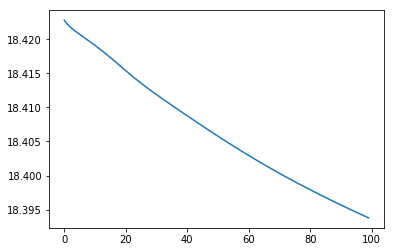

--------------------------ROUND: 1 --------------------------
len(entities) 9368
len(entities) 9368
len(entities) 9368
len(entities) 9368
len(entities) 9368
len(entities) 9368
len(entities) 9368
len(entities) 9368
len(entities) 9368
len(entities) 9368
Starting Expert: 0
(1000,)
single_lose (1000,)
Writing TensorBoard summaries to log/example
epoch: 1
self.__total_loss 17631.87365821749
epoch: 2
self.__total_loss 14753.931812856346
epoch: 3
self.__total_loss 13112.614608662203
epoch: 4
self.__total_loss 12598.672111667693
epoch: 5
self.__total_loss 12455.741877894849
epoch: 6
self.__total_loss 12340.254233086482
epoch: 7
self.__total_loss 12228.676405934617
epoch: 8
self.__total_loss 12070.760412825271
epoch: 9
self.__total_loss 11935.301519571804
epoch: 10
self.__total_loss 11830.856407506391
Starting Expert: 1
(1000,)
single_lose (1000,)
Writing TensorBoard summaries to log/example
epoch: 1
self.__total_loss 17034.878801092505
epoch: 2
self.__total_loss 15511.280121669173
epoch: 3
sel

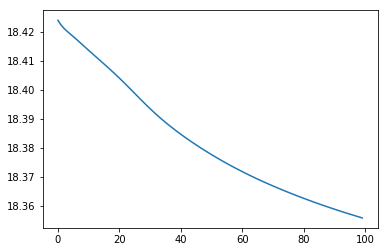

--------------------------ROUND: 2 --------------------------
len(entities) 9368
len(entities) 9368
len(entities) 9368
len(entities) 9368
len(entities) 9368
len(entities) 9368
len(entities) 9368
len(entities) 9368
len(entities) 9368
len(entities) 9368
Starting Expert: 0
(1000,)
single_lose (1000,)
Writing TensorBoard summaries to log/example
epoch: 1
self.__total_loss 17254.246800217777
epoch: 2
self.__total_loss 14192.461486550048
epoch: 3
self.__total_loss 12601.362223763019
epoch: 4
self.__total_loss 12102.071052778512
epoch: 5
self.__total_loss 11969.387277217582
epoch: 6
self.__total_loss 11931.29218922928
epoch: 7
self.__total_loss 11768.575367681682
epoch: 8
self.__total_loss 11584.940194536
epoch: 9
self.__total_loss 11459.925986701623
epoch: 10
self.__total_loss 11373.383864066564
Starting Expert: 1
(1000,)
single_lose (1000,)
Writing TensorBoard summaries to log/example
epoch: 1
self.__total_loss 22602.860929004848
epoch: 2
self.__total_loss 19940.00038640946
epoch: 3
self.__

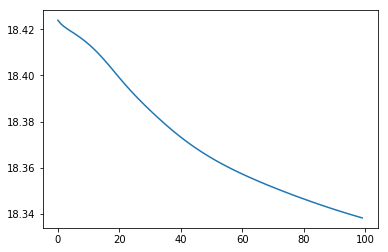

--------------------------------------Here What Iam Looking For--------------------------------------
(9368, 10)


----------------Expert: 0 ---------------------
students 0.9702545
college 0.96757466
student 0.9661591
school 0.93698925
campus 0.93564266
faculty 0.9134759
semester 0.9058842
colleges 0.8937213
programs 0.8927386
byu 0.8902891
undergraduate 0.8894873
university 0.8820826
program 0.87141293
schools 0.86461663
graduate 0.8634738
academic 0.8457893
campuses 0.839512
graduation 0.8255658
education 0.8165045
tuition 0.7948647
freshmen 0.7904045
enrollment 0.773103
graduates 0.7476339
classroom 0.73600537
degree 0.7281495
teacher 0.71957177
teachers 0.7161352
undergraduates 0.7031194
curriculum 0.69958377
scholarships 0.69776714
scholarship 0.6793792
classrooms 0.6558641
year 0.6533017
years 0.6507316
elementary 0.6466681
universities 0.62719035
alumni 0.5972328
professors 0.5959414
teaching 0.593502
diploma 0.58340394
kindergarten 0.5683379
extracurricular 0.56309295
admissio

date 0.463761
dec 0.45461416
monday 0.43920517
dodge 0.43715194
sunday 0.42820418
wheel 0.42705303
aug 0.41943446
editorial 0.41925302
magazine 0.4116229
modified 0.4029465
friday 0.40055007
driver 0.40027285
daily 0.40002313
anniversary 0.3964363
till 0.3925323
wheels 0.39240223
updated 0.38474593
bulletin 0.3843024
edition 0.38062045
sometime 0.37765303
obituary 0.3768561
hatch 0.37548062
reprint 0.37387925
rightmost 0.37323454
wednesday 0.37283412
cab 0.3722963
window 0.37100628
driveway 0.36807203
manila 0.36623812
unaltered 0.3654454
copy 0.3644751
streets 0.36131188
sidewalk 0.3551067
windows 0.35484365
release 0.350844
maj 0.35044038
moon 0.3463262
ballot 0.34542784
bent 0.34320325
midnight 0.3424678
generic 0.3398788
corners 0.33692536
oregonian 0.3357302
sheet 0.3338419
bar 0.3327724
door 0.33205172
framed 0.33196595
box 0.33149624
newspapers 0.33031338
piece 0.32881314
jan 0.32856736
occupants 0.3285075
commemorative 0.32812667
pages 0.3268861
domingo 0.32544926
proceedings 0

In [27]:

#we traind it for 3 round here for simplicity

for moe in range(3):
    print('--------------------------ROUND:',moe,'--------------------------')
    models=[]
    experts=10
    g_k_J=np.transpose(g_k_J)
    for k in range(experts):
        
       #self, count_,entities,fea,embedding_size, entities_size,g_K_j,empEnt,empFea, entbias,feabias,max_vocab_size=100000, min_occurrences=0,
   
        models.append(GloVeModelMOE(cooccurrence_matrix,fea,ent,np.array(g_k_J[k]),np.array(empFea[k]),
                                    np.array(empEnt[k]),np.array(feabias[k]),np.array(entbias[k]),
                                    embedding_size=10, entities_size=len(ent), min_occurrences=0,
                               learning_rate=0.5, batch_size=1000))
    empEntTemp=[]
    empFeaTemp=[]
    errFeaTemp=[]
    entbiasTemp=[]
    feabiasTemp=[]
    for j in range(experts):
        print('Starting Expert:', j)
        models[j].fit_to_corpus(cooccurrence_matrix)
        models[j].train(num_epochs=10, log_dir="log/example", summary_batch_interval=100)
        feabiasTemp.append(models[j].context_biasesE)
        entbiasTemp.append(models[j].focal_biasesW)
        empFeaTemp.append(models[j].embeddings_en)
        empEntTemp.append(models[j].embeddings)
        errFeaTemp.append(models[j].errorEstimation)
    empEnt=np.array(empEntTemp)
    empFea=np.array(empFeaTemp)
    errFea=np.array(errFeaTemp)
    entbias=np.array(entbiasTemp)
    feabias=np.array(feabiasTemp)
    scores=E_step(errFea)#E_step()#
    print(np.array(scores).shape)
    if (moe)<3:
        g_k_J,loss=moeGate((scores),gloveVectors)
        plt.plot(loss)
        plt.show()


# In[274]:
print('--------------------------------------Here What Iam Looking For--------------------------------------')

print(np.array(g_k_J).shape)
g_k_J=np.transpose(g_k_J)
for k in range(experts):
    print()
    print()
    print('----------------Expert:',k,'---------------------')
    count=0
    for i in np.argsort(np.array(g_k_J)[k])[::-1]:
        
        if count<100 and k==np.argmax(g_k_J[:,i]):
            count=count+1
            print(fea[i],g_k_J[k][i])

print('--------------------------------------------------------------------------')
# In[302]:


ex=[[],[],[],[],[],[],[],[],[],[]]
exV=[[],[],[],[],[],[],[],[],[],[]]
exscore=[[],[],[],[],[],[],[],[],[],[]]
#print('Here an Erorr',len(fea),np.array(g_k_J).shape)

for i in range(len(fea)):
    x=np.argmax(g_k_J[:,i])
    if g_k_J[x][i]<=1 and g_k_J[x][i]>=.1:
        exscore[x].append(g_k_J[x][i])
        ex[x].append(fea[i])#features for each expert
        exV[x].append(empFea[x][i])#features vectors
        
        

# In[9]:



In [28]:
#saving the entity embedings, features, and features directions for each facet in a seperate file

print(np.array(np.array(empEnt)).shape)
orderd_features=fea
dim_5_all=np.array(empEnt) # entity embeddings for each experts 
featuersDirection_for_each_facet=np.array(empFea)
try:
    '''write2dArray(mdsMAIN,base_folder_results+'GloveBaseline')
    write2dArray(orderd_features_directions,base_folder_results+'GloveBaselineOrderd_features_directions')'''
    for i in range(experts):

        write2dArray(dim_5_all[i],base_folder_results+'ent_for_expert_'+str(i))
        write2dArray(featuersDirection_for_each_facet[i],base_folder_results+'fea_for_expert_'+str(i))
        write2dArray(exV[i],base_folder_results+'exV_fea_for_expert_'+str(i))
        write1dArray(ex[i],base_folder_results+'ex_fea_for_expert_'+str(i))
except:
    print('didnt save')

(10, 3721, 10)
starting array
successful write //media/rana/2TB/MoECode/results/ent_for_expert_0
starting array
successful write //media/rana/2TB/MoECode/results/fea_for_expert_0
starting array
successful write //media/rana/2TB/MoECode/results/exV_fea_for_expert_0
starting array
successful write //media/rana/2TB/MoECode/results/ex_fea_for_expert_0
starting array
successful write //media/rana/2TB/MoECode/results/ent_for_expert_1
starting array
successful write //media/rana/2TB/MoECode/results/fea_for_expert_1
starting array
successful write //media/rana/2TB/MoECode/results/exV_fea_for_expert_1
starting array
successful write //media/rana/2TB/MoECode/results/ex_fea_for_expert_1
starting array
successful write //media/rana/2TB/MoECode/results/ent_for_expert_2
starting array
successful write //media/rana/2TB/MoECode/results/fea_for_expert_2
starting array
successful write //media/rana/2TB/MoECode/results/exV_fea_for_expert_2
starting array
successful write //media/rana/2TB/MoECode/results/